#### import all libraries

In [328]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re 
import string
from nltk.stem.wordnet import WordNetLemmatizer
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer

import lime
import lime.lime_text

## 1. Import excel dataset

In [329]:
file="bbc_dataset_news_classifier"
print(os.path.abspath(file))
cwd=os.getcwd()
dataset_filepath=cwd+'/Desktop/news_classify/dataset.xls'
dataset=pd.read_excel(dataset_filepath)

C:\Users\vivyadav\bbc_dataset_news_classifier


## 2. Dataset Exploration

### Distribution of data across 5 categories

category
business         510
entertainment    386
politics         386
sport            386
tech             386
Name: text, dtype: int64


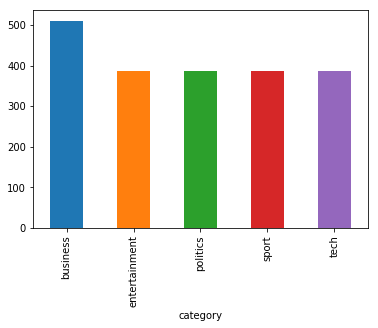

In [330]:
cat=dataset.groupby('category')['text'].count()
cat.plot.bar()
print(cat)

so dataset is distributed uniformly across all categories. So this dataset is not biased towards any category.

### 2.1 Clean dataset

In [331]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


In [332]:
def get_words( text ): 
    stop_free = " ".join([i for i in text.lower().split() if i not in stop]) #to remove words like is,the,am,I,to
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude) #to remove punctuations , . '
    digit_free=' '.join(s for s in punc_free.split() if not any(c.isdigit() for c in s))
    normalized = " ".join(lemma.lemmatize(word) for word in digit_free.split()) #using wordnetlemmatizer to replace words
    return normalized
   

##### Comparison between before and after cleaning dataset:

Before cleaning dataset article 1:

In [333]:
print(dataset.text[0])


Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-sp

Removing stopwords,puncutations and lematizing all text present in corpus 

In [334]:
dataset.text=[get_words(i) for i in dataset.text]

After cleaning dataset article 1:

In [335]:
dataset.text[0]

'quarterly profit u medium giant timewarner jumped three month december yearearlier firm one biggest investor google benefited sale highspeed internet connection higher advert sale timewarner said fourth quarter sale rose profit buoyed oneoff gain offset profit dip warner bros le user aol time warner said friday owns searchengine google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company said aols underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aols existing customer highspeed broadband timewarner also restate result following probe u security exchange commission sec close concluding time warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped boxoffice flop alexander catwoman sharp contrast yearearlier third final film lord ring trilogy boosted re

### 2.2 WordClouds

In [336]:
def plot_word_cloud(text,category):
    wordcloud = WordCloud(max_font_size=250, max_words=300, background_color="white", height=500,width=1400,stopwords=stop).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('WordCloud of {} articles'.format(category))
    plt.axis("off")
    plt.show()
    wordcloud.to_file('Desktop/{}.png'.format(category))

#### 2.2.1 WordCloud of entertainment articles in dataset

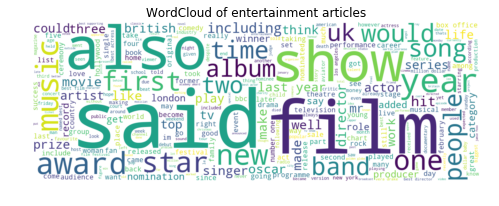

In [337]:
entertainment_words=' '.join(dataset.text[dataset.category=='entertainment'])
plot_word_cloud(entertainment_words,'entertainment')

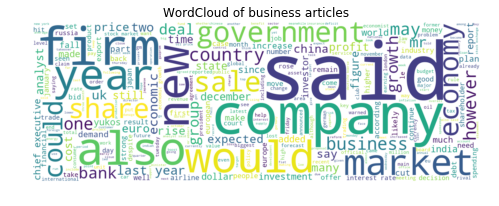

In [338]:
business_words=' '.join(dataset.text[dataset.category=='business'])
plot_word_cloud(business_words,'business')

#### 2.2.2 WordCloud of politics articles

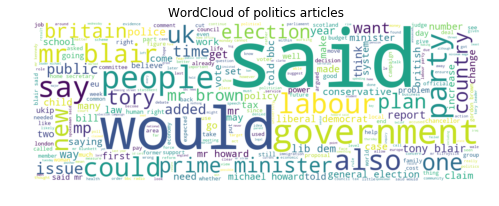

In [339]:
politics_words=' '.join(dataset.text[dataset.category=='politics'])
plot_word_cloud(politics_words,'politics')

#### 2.2.4 WordCloud of tech articles

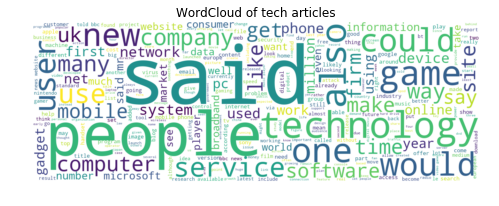

In [340]:
tech_words=' '.join(dataset.text[dataset.category=='tech'])
plot_word_cloud(tech_words,'tech')

#### 2.2.5 WordCloud of spotrs articles

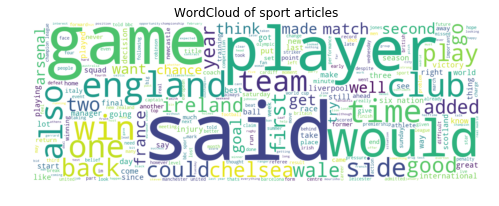

In [341]:
sport_words=' '.join(dataset.text[dataset.category=='sport'])
plot_word_cloud(sport_words,'sport')

In [342]:
dataset['category_id'] = dataset['category'].factorize()[0]
print(dataset.category_id.unique())

[0 1 2 3 4]


In [343]:
category_id_df = dataset[['category', 'category_id']].drop_duplicates().sort_values('category_id')
print(category_id_df)
category_to_id = dict(category_id_df.values)
print(category_to_id)
id_to_category = dict(category_id_df[['category_id', 'category']].values)


           category  category_id
0          business            0
510   entertainment            1
896        politics            2
1282          sport            3
1668           tech            4
{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


## 3. TF-IDF

Need for tf-idf :



In [344]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')


In [345]:
#features = tfidf.fit_transform(dataset.text[dataset.category=='business']).toarray()
features = tfidf.fit_transform(dataset.text).toarray()
features1= tfidf.fit_transform(dataset.text)
labels = dataset.category_id

In [346]:
print("Shape of features is (rows,columns) \t: {}".format(features.shape))
print("length of tfidf generated vocabulary \t: {}".format(len(tfidf.vocabulary_)))
print("Number of documents in corpus \t\t: {}".format(dataset.category.count()))

Shape of features is (rows,columns) 	: (2054, 12276)
length of tfidf generated vocabulary 	: 12276
Number of documents in corpus 		: 2054


Above features matrix has 2054 rows and 11908 columns.
<img src="Desktop/matrix1.png">

In [347]:
print(features1.shape)
print(features1[0])

(2054, 12276)
  (0, 8516)	0.07680011423613196
  (0, 8347)	0.1723247932636681
  (0, 6567)	0.04636108680440718
  (0, 4356)	0.04904190439297075
  (0, 5634)	0.07144309945507367
  (0, 6851)	0.032010822821698676
  (0, 2579)	0.04539301215239048
  (0, 3921)	0.03458439793241568
  (0, 1002)	0.043758098611945455
  (0, 5409)	0.055061315902704175
  (0, 4450)	0.11684315699748124
  (0, 921)	0.09191132010458987
  (0, 9529)	0.09459032807496441
  (0, 4860)	0.12172732203034461
  (0, 5368)	0.11787008220986432
  (0, 2103)	0.05966248456269214
  (0, 4842)	0.08669898124914113
  (0, 193)	0.07236042679620659
  (0, 9268)	0.041864479767502814
  (0, 4097)	0.1198140176138698
  (0, 8509)	0.12099845120883647
  (0, 9177)	0.08812164772680595
  (0, 7429)	0.08237721070983617
  (0, 4220)	0.05966248456269214
  (0, 7378)	0.07680011423613196
  :	:
  (0, 6223)	0.056480595708886285
  (0, 11609)	0.05151492488766413
  (0, 6570)	0.09191132010458987
  (0, 6855)	0.08142822670952125
  (0, 4861)	0.09403163377817574
  (0, 5372)	0.0856

In [348]:
for key in sorted(tfidf.vocabulary_):
   print(key, tfidf.vocabulary_[key])

aaa 0
aaa title 1
abandoned 2
abandoning 3
abbas 4
abbott 5
abc 6
ability 7
ability influence 8
able 9
able access 10
able make 11
able play 12
able watch 13
abn 14
abn amro 15
abolish 16
abolishing 17
abortion 18
abortion drama 19
abortionist 20
abroad 21
absence 22
absent 23
absolute 24
absolutely 25
abuse 26
abused 27
abusive 28
ac 29
ac milan 30
academic 31
academy 32
academy award 33
academy film 34
academy motion 35
academy voter 36
accelerated 37
accelerating 38
accept 39
acceptable 40
acceptance 41
accepted 42
accepting 43
accepts 44
access 45
access home 46
access information 47
access mobile 48
access net 49
access point 50
access service 51
accessed 52
accessible 53
accessing 54
accession 55
accident 56
acclaim 57
acclaimed 58
accolade 59
accommodation 60
accompanied 61
accompanying 62
accomplished 63
according 64
according analyst 65
according figure 66
according financial 67
according industry 68
according mr 69
according new 70
according official 71
according recent 72
ac

asking 593
asking people 594
asks 595
aspect 596
aspiration 597
ass 598
ass cost 599
assault 600
assembled 601
assembly 602
assembly government 603
assembly member 604
assessment 605
asset 606
assigned 607
assist 608
assistance 609
assistant 610
assistant bos 611
assisting 612
associate 613
associated 614
associated press 615
association 616
association america 617
association athletics 618
association chief 619
association said 620
assume 621
assumed 622
assuming 623
assumption 624
assurance 625
assure 626
assured 627
aston 628
aston villa 629
asylum 630
asylum claim 631
asylum immigration 632
asylum seeker 633
asymmetric 634
asymmetric digital 635
athens 636
athens august 637
athens game 638
athens olympics 639
athlete 640
athletics 641
athletics federation 642
athletics ruling 643
atlantic 644
atmosphere 645
atomic 646
atomic bomb 647
att 648
attached 649
attachment 650
attachment email 651
attack 652
attack website 653
attacked 654
attacked tory 655
attacker 656
attacking 657
attem

bullet 1343
bulletin 1344
bullish 1345
bullying 1346
bump 1347
bumper 1348
bunch 1349
bundled 1350
buoyant 1351
burden 1352
bureau 1353
bureaucracy 1354
burger 1355
buried 1356
burn 1357
burnley 1358
burst 1359
bus 1360
bush 1361
bush administration 1362
bush said 1363
business 1364
business group 1365
business leader 1366
business method 1367
business model 1368
business need 1369
business practice 1370
business said 1371
business sale 1372
business uk 1373
businessman 1374
bust 1375
busy 1376
butler 1377
button 1378
buy 1379
buyer 1380
buying 1381
buyout 1382
buzz 1383
byelections 1384
bypassed 1385
byrne 1386
byrne hayes 1387
ca 1388
cabinet 1389
cabinet ally 1390
cabinet minister 1391
cabinet office 1392
cable 1393
cafe 1394
cairn 1395
cake 1396
calculated 1397
calculation 1398
calculation second 1399
calendar 1400
california 1401
californiabased 1402
californian 1403
called 1404
called action 1405
called government 1406
called mr 1407
calling 1408
callup 1409
calm 1410
cambridge 1

crack 2342
crackdown 2343
cracking 2344
craig 2345
craig bellamy 2346
crap 2347
crash 2348
crashed 2349
crass 2350
crazy 2351
create 2352
create job 2353
create new 2354
created 2355
creates 2356
creating 2357
creation 2358
creative 2359
creativity 2360
creator 2361
credential 2362
credibility 2363
credible 2364
credit 2365
credit card 2366
credit rating 2367
credit suisse 2368
credited 2369
creditor 2370
crew 2371
crime 2372
crime scene 2373
crime unit 2374
criminal 2375
criminal charge 2376
criminal gang 2377
criminal offence 2378
criminal trial 2379
criminally 2380
crippled 2381
crisis 2382
cristiano 2383
cristiano ronaldo 2384
criterion 2385
critic 2386
critic claim 2387
critic say 2388
critical 2389
critical acclaim 2390
critical security 2391
critically 2392
critically acclaimed 2393
criticise 2394
criticised 2395
criticising 2396
criticism 2397
crop 2398
cross 2399
cross country 2400
crossed 2401
crossing 2402
crowd 2403
crowded 2404
crown 2405
crown year 2406
crowned 2407
cruci

engaged 3342
engagement 3343
engaging 3344
engine 3345
engineer 3346
engineering 3347
england 3348
england captain 3349
england coach 3350
england defeat 3351
england france 3352
england game 3353
england nation 3354
england player 3355
england said 3356
england squad 3357
england wale 3358
england year 3359
english 3360
englishspeaking 3361
enhance 3362
enhanced 3363
enjoy 3364
enjoyed 3365
enjoying 3366
enjoys 3367
enlarged 3368
enormous 3369
enormously 3370
enron 3371
ensure 3372
ensure site 3373
ensured 3374
ensures 3375
ensuring 3376
enter 3377
enter market 3378
entered 3379
entered chart 3380
entering 3381
enterprise 3382
entertain 3383
entertainer 3384
entertaining 3385
entertainment 3386
entertainment industry 3387
enthusiasm 3388
enthusiast 3389
entire 3390
entirely 3391
entitled 3392
entourage 3393
entrepreneur 3394
entry 3395
envelope 3396
environment 3397
environment said 3398
environmental 3399
environmental group 3400
environmental protection 3401
epic 3402
epidemic 3403


georgia 4341
gerard 4342
gere 4343
gerhard 4344
gerhard schroeder 4345
german 4346
german chancellor 4347
germany 4348
germany economy 4349
gerrard 4350
gerrards 4351
gesture 4352
getting 4353
getting way 4354
giamatti 4355
giant 4356
giant electronic 4357
giant gazprom 4358
giant microsoft 4359
giant said 4360
giant yukos 4361
gibson 4362
gift 4363
gig 4364
gigabyte 4365
giggs 4366
gill 4367
girl 4368
girlfriend 4369
giveaway 4370
given 4371
given chance 4372
giving 4373
giving evidence 4374
gizmondo 4375
glad 4376
glasgow 4377
glass 4378
glastonbury 4379
glazer 4380
glen 4381
glenn 4382
glittering 4383
global 4384
global economic 4385
global economy 4386
global poverty 4387
global warming 4388
globalisation 4389
globally 4390
globe 4391
globe award 4392
gloomy 4393
glorious 4394
glory 4395
gloucester 4396
gm 4397
gmt 4398
gmt wednesday 4399
goal 4400
goal game 4401
goalkeeper 4402
god 4403
going 4404
going detained 4405
going forward 4406
going happen 4407
going look 4408
going make 

intense 5341
intensive 5342
intent 5343
intention 5344
interact 5345
interaction 5346
interactive 5347
interactive medium 5348
interactive tv 5349
intercept 5350
intercepted 5351
interested 5352
interesting 5353
interface 5354
internal 5355
internal control 5356
international 5357
international association 5358
international career 5359
international development 5360
international federation 5361
international film 5362
international finance 5363
international monetary 5364
international olympic 5365
international rugby 5366
internationally 5367
internet 5368
internet access 5369
internet american 5370
internet business 5371
internet connection 5372
internet explorer 5373
internet protocol 5374
internet service 5375
internet telephony 5376
internet use 5377
internet user 5378
interoperability 5379
interpretation 5380
interrupted 5381
interval 5382
intervened 5383
intervention 5384
interview 5385
interview bbc 5386
interviewed 5387
intoppa 5388
introduce 5389
introduced 5390
introduced 

make change 6340
make clear 6341
make decision 6342
make difference 6343
make difficult 6344
make easier 6345
make easy 6346
make final 6347
make good 6348
make harder 6349
make le 6350
make million 6351
make mistake 6352
make money 6353
make music 6354
make offer 6355
make people 6356
make phone 6357
make possible 6358
make real 6359
make sense 6360
make sort 6361
make statement 6362
make sure 6363
make use 6364
make way 6365
make work 6366
makelele 6367
maker 6368
makeup 6369
making 6370
making difficult 6371
making film 6372
making music 6373
making sure 6374
malaysia 6375
malcolm 6376
malcolm glazer 6377
maldives 6378
male 6379
male female 6380
malfunction 6381
malicious 6382
malicious code 6383
malicious hacker 6384
malicious program 6385
mama 6386
man 6387
man man 6388
man said 6389
man shoe 6390
man utd 6391
manage 6392
managed 6393
management 6394
manager 6395
manager rafael 6396
manager said 6397
manager sir 6398
managerial 6399
managing 6400
managing director 6401
manchester 

october december 7340
october mr 7341
october year 7342
odd 7343
odds 7344
odeon 7345
odriscoll 7346
ofcom 7347
offence 7348
offended 7349
offender 7350
offending 7351
offensive 7352
offer 7353
offer buy 7354
offer lse 7355
offer service 7356
offered 7357
offering 7358
office 7359
office chart 7360
office deputy 7361
office hit 7362
office minister 7363
office national 7364
office power 7365
office record 7366
office said 7367
office say 7368
officer 7369
officer said 7370
official 7371
official figure 7372
official said 7373
official spokesman 7374
official website 7375
officially 7376
offline 7377
offset 7378
offshore 7379
offside 7380
ogara 7381
ogara stringer 7382
ogaras 7383
oh 7384
oil 7385
oil company 7386
oil field 7387
oil firm 7388
oil gas 7389
oil giant 7390
oil natural 7391
oil price 7392
oil producer 7393
oil production 7394
ok 7395
okay 7396
okelly 7397
okelly oconnell 7398
okonedo 7399
old 7400
old labour 7401
old school 7402
old trafford 7403
older 7404
older people 740

production unit 8339
productive 8340
productivity 8341
prof 8342
professional 8343
professionalism 8344
professor 8345
profile 8346
profit 8347
profit fall 8348
profit month 8349
profit rise 8350
profit year 8351
profitability 8352
profitable 8353
profound 8354
profoundly 8355
program 8356
program internet 8357
programme 8358
programme digital 8359
programme mr 8360
programmed 8361
programmer 8362
programming 8363
progress 8364
prohibited 8365
project 8366
project manager 8367
project said 8368
projected 8369
projection 8370
proliferation 8371
prominence 8372
prominent 8373
promise 8374
promised 8375
promising 8376
promote 8377
promoted 8378
promoter 8379
promotes 8380
promoting 8381
promotion 8382
promotional 8383
prompt 8384
prompted 8385
prompting 8386
promptly 8387
proof 8388
prop 8389
propaganda 8390
proper 8391
properly 8392
property 8393
proportion 8394
proposal 8395
proposal mean 8396
propose 8397
proposed 8398
proposes 8399
proposing 8400
proposition 8401
prosecuted 8402
prose

said evidence 9339
said expected 9340
said expects 9341
said fact 9342
said family 9343
said far 9344
said feel 9345
said felt 9346
said figure 9347
said film 9348
said firm 9349
said following 9350
said foreign 9351
said french 9352
said friday 9353
said future 9354
said game 9355
said glad 9356
said going 9357
said good 9358
said got 9359
said government 9360
said graham 9361
said great 9362
said group 9363
said growing 9364
said growth 9365
said happy 9366
said hard 9367
said help 9368
said home 9369
said hope 9370
said hoped 9371
said house 9372
said huge 9373
said ian 9374
said idea 9375
said im 9376
said important 9377
said industry 9378
said issue 9379
said ive 9380
said john 9381
said jupiter 9382
said ken 9383
said know 9384
said labour 9385
said latest 9386
said law 9387
said le 9388
said legal 9389
said lib 9390
said liberal 9391
said like 9392
said look 9393
said looked 9394
said looking 9395
said lord 9396
said lot 9397
said main 9398
said major 9399
said make 9400
said ma

st james 10338
st mary 10339
stabbed 10340
stability 10341
stable 10342
stade 10343
stade francais 10344
stade france 10345
stadium 10346
staff 10347
stage 10348
staged 10349
staggering 10350
stake 10351
stalwart 10352
stamford 10353
stamford bridge 10354
stamp 10355
stamp duty 10356
stance 10357
stand 10358
stand election 10359
standard 10360
standard poor 10361
standing 10362
standing ovation 10363
stanley 10364
staple 10365
star 10366
star imelda 10367
star including 10368
star said 10369
star war 10370
star zach 10371
starred 10372
starring 10373
starring tom 10374
start 10375
start game 10376
start producing 10377
start season 10378
start year 10379
started 10380
started work 10381
starting 10382
starting lineup 10383
startup 10384
state 10385
state control 10386
state department 10387
state economy 10388
state law 10389
state mr 10390
state oil 10391
state pension 10392
state said 10393
state university 10394
statecontrolled 10395
stated 10396
statement 10397
statement firm 10398

turning 11338
turnout 11339
turnover 11340
tv 11341
tv channel 11342
tv comedy 11343
tv content 11344
tv digital 11345
tv film 11346
tv mobile 11347
tv network 11348
tv picture 11349
tv presenter 11350
tv programme 11351
tv said 11352
tv screen 11353
tv series 11354
tv service 11355
tv set 11356
tv station 11357
tv viewer 11358
tweaked 11359
twice 11360
twickenham 11361
twin 11362
twist 11363
twoday 11364
twothirds 11365
twotime 11366
twoyear 11367
twoyear ban 11368
tycoon 11369
type 11370
typical 11371
typically 11372
tzekos 11373
ubiquitous 11374
ubs 11375
uefa 11376
uefa cup 11377
ugly 11378
uk 11379
uk biggest 11380
uk business 11381
uk chancellor 11382
uk chart 11383
uk economy 11384
uk film 11385
uk firm 11386
uk foreign 11387
uk france 11388
uk game 11389
uk gamers 11390
uk government 11391
uk highest 11392
uk household 11393
uk housing 11394
uk independence 11395
uk month 11396
uk mr 11397
uk music 11398
uk number 11399
uk people 11400
uk plan 11401
uk said 11402
uk sale 11403


#### List of words removed by TfidfVectorizer

Terms that were ignored because they either:

    1) occurred in too many documents (max_df)
    2) occurred in too few documents (min_df)
    3) were cut off by feature selection (max_features).

In [349]:
tfidf_stop_words=tfidf.get_stop_words()
print(tfidf_stop_words)

frozenset({'any', 'them', 'back', 'whose', 'some', 'hereafter', 'less', 'when', 'describe', 'thick', 'third', 'also', 'whereupon', 'am', 'may', 'yourself', 'somewhere', 'almost', 'noone', 'name', 'via', 'one', 'seems', 'such', 'whatever', 'my', 'our', 'very', 'most', 'cannot', 'beside', 'hence', 'latterly', 'now', 'always', 'wherein', 'hers', 'never', 'himself', 'only', 'take', 'within', 'from', 'done', 'meanwhile', 'nowhere', 'whenever', 'at', 'sometime', 'again', 'but', 'ours', 'than', 'what', 'except', 'seem', 'beyond', 'however', 'each', 'could', 'herself', 'through', 'whether', 'please', 'show', 'there', 'as', 'thru', 'we', 'eight', 'why', 'along', 'have', 'give', 'herein', 'cry', 'can', 'mostly', 'by', 'amoungst', 'upon', 'must', 'on', 'thence', 'has', 'though', 'eg', 'be', 'much', 'call', 're', 'many', 'above', 'because', 'into', 'side', 'becomes', 'six', 'nevertheless', 'few', 'out', 'therefore', 'its', 'seemed', 'among', 'which', 'thin', 'to', 'well', 'ever', 'none', 'bill', '

Find in how many documents word 'quarterly' appears

In [350]:
#word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
#sorted_by_idf = [(k, word2tfidf[k]) for k in sorted(word2tfidf, key=word2tfidf.get, reverse=True)]
#print(sorted_by_idf)

#### Making sense of TFIDF values 

function to sort a row of features matrix according to their tfidf scores and then print words having top 25 tfidf scores

In [351]:
def top_tfidf_feats_1row(vocab,row):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:25]
    top_feats = [(vocab[i] , row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['features','tfidf']
    return df

So above function takes a single row and sorts its terms according to tfidf scores

<img src="Desktop/sort_1row.png">

##### printing words having top 25 tfidf scores in document 1 which belongs to category 'business'

In [352]:
print(top_tfidf_feats(tfidf.get_feature_names(),features[0]))

NameError: name 'top_tfidf_feats' is not defined

So now instead of doing it on a single article, we have to arrange words according to their tfidf scores in whole corpus belonging to a particular category. 

Creating a series of mean tfidf scores of each words present in vocabulary <img src="Desktop/cal_mean_of_tfidf.png">

In [353]:
def top_mean_feats(features, vocab, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    D = features

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats_1row(vocab,tfidf_means)

In [354]:
def plot_bar_x(top_words,i):
    df = pd.DataFrame({'words':top_words.features, 'tfidf scores':top_words.tfidf})
    ax = df.plot.barh(x='words', y='tfidf scores',align='center', color='#3F5D7D',fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score of category {}".format(id_to_category[i]), labelpad=16, fontsize=14)
    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=1)
    


 Top 25 words according to tfidf scores belonging to 0 category
    features     tfidf
0     profit  0.014236
1       bank  0.014213
2      share  0.012807
3       euro  0.012225
4    economy  0.011909
5        oil  0.011687
6       rate  0.011548
7     growth  0.011086
8       sale  0.011022
9      price  0.010784
10   airline  0.010602
11     stock  0.010050
12     china  0.009963
13     india  0.009446
14     yukos  0.009164
15  economic  0.008428
16       car  0.007547
17      firm  0.007291
18   deficit  0.007172
19   quarter  0.007123
20  deutsche  0.007097
21    dollar  0.006979
22   russian  0.006773
23     stake  0.006481
24      debt  0.006167

 Top 25 words according to tfidf scores belonging to 1 category
      features     tfidf
0         film  0.039808
1        award  0.024565
2         band  0.017739
3        album  0.016927
4     festival  0.015730
5        oscar  0.013545
6         best  0.012596
7        chart  0.012427
8        music  0.011872
9        actor  0.0114

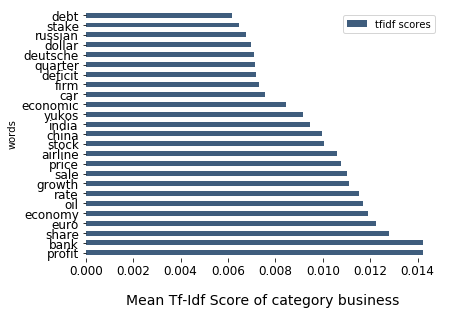

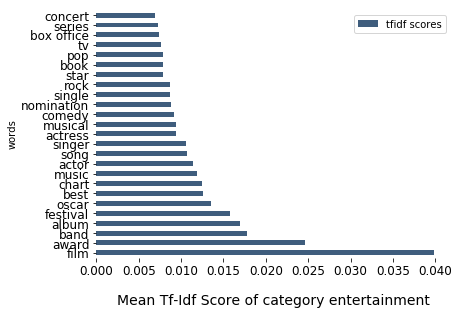

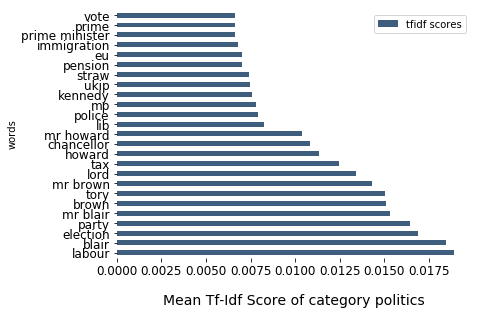

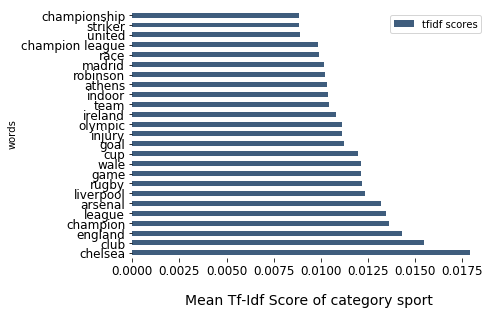

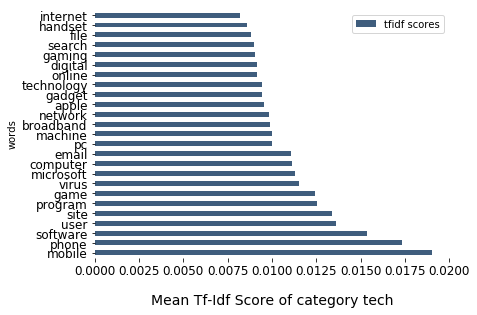

In [355]:
for i in dataset.category_id.unique():
    print("\n Top 25 words according to tfidf scores belonging to {} category".format(i))
    top_25_all_corpus=top_mean_feats(features[dataset.category_id==i],tfidf.get_feature_names())
    print(top_25_all_corpus)
    plot_bar_x(top_25_all_corpus,i)

#### Print unigrams and bigrams corresponding to each category

In [356]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . oil
       . bank
       . growth
  . Most correlated bigrams:
       . analyst said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . actor
       . award
       . film
  . Most correlated bigrams:
       . film festival
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . tory
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . cup
       . champion
       . coach
  . Most correlated bigrams:
       . world cup
       . bbc sport
       . champion league
# 'tech':
  . Most correlated unigrams:
       . computer
       . technology
       . user
  . Most correlated bigrams:
       . news website
       . let people
       . mobile phone


#### Compare various models (Logistic regression, RandomForest, Naive Bayes)

In [357]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\vivyadav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [358]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.972261
MultinomialNB             0.965437
RandomForestClassifier    0.779140
Name: accuracy, dtype: float64

## Creating logistic regression model for given dataset

In [359]:
model = LogisticRegression(random_state=0)

##### Split data into training and testing parts

In [360]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataset.index, test_size=0.33, random_state=0)

##### Fit logistic regression model using training dataset

In [361]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### predict y and its probability, for testing dataset using above logistic regression model

In [362]:
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


In [363]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')

[[171   0   1   0   1]
 [  1 122   2   0   0]
 [  9   0 115   0   0]
 [  0   0   1 140   0]
 [  2   1   1   2 109]]


In [364]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(dataset.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['filename', 'text']])
      print('')

'politics' predicted as 'business' : 9 examples.


,filename,text
958,063.txt,effort made protect worker day christmas day n...
1073,178.txt,engineering firm balfour beatty five railway m...
971,076.txt,ministry defence criticised soaring spending c...
1103,208.txt,britain offered send company gurkha assist tsu...
933,038.txt,campaigner stage rally calling border rail lin...
1057,162.txt,government change law give protection employee...
1135,240.txt,group mp peer called tightening regulation con...
985,090.txt,climate change could completely control within...
918,023.txt,failed government scheme offer uk university c...



'tech' predicted as 'business' : 2 examples.


,filename,text
1843,176.txt,brother sister u convicted sending hundred tho...
1799,132.txt,brother sister u convicted sending hundred tho...



'entertainment' predicted as 'politics' : 2 examples.


,filename,text
519,010.txt,uganda authority banned play vagina monologue ...
711,202.txt,mp urged bbc give watchdog freedom scrutinise ...



'tech' predicted as 'sport' : 2 examples.


,filename,text
1807,140.txt,uk gamers getting chance take part tournament ...
1941,274.txt,two uk gamers embark world tour part lucrative...


In [365]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Test model on untrained corpus

In [366]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Machine learning is next big thing",
         "next indian general election will be held in 2019"]
text_features = tfidf.transform(texts)
#print(text_features)
predictions = model.predict(text_features)
#print(predictions)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Machine learning is next big thing"
  - Predicted as: 'tech'

"next indian general election will be held in 2019"
  - Predicted as: 'politics'



### Create news_predict function to classify new text

In [367]:
def news_predict(text):
    texty=np.array([text])
    text_features = tfidf.transform(texty)
    predictions = model.predict(text_features)
    print(predictions)
    for text, predicted in zip(texty, predictions):
        print('"{}"'.format(text))
        print("  - Predicted as: '{}'".format(id_to_category[predicted]))
        print("")

In [368]:
news_predict("Kotak Mahindra Bank’s decision to take the Reserve Bank of India (RBI) to court over the contentious issue of promoter shareholding was preceded by the central bank slapping a show-cause notice on the private-sector lender and accusing it of “wilful non-disclosure of information”, according to legal documents reviewed by The Wire.The notice, which threatened fines for allegedly keeping the central bank in the dark over the lender’s strategy for reducing the stake of its promoters, likely sent alarm bells ringing at Kotak and may have prompted its decision to move the Bombay high court.")

[0]
"Kotak Mahindra Bank’s decision to take the Reserve Bank of India (RBI) to court over the contentious issue of promoter shareholding was preceded by the central bank slapping a show-cause notice on the private-sector lender and accusing it of “wilful non-disclosure of information”, according to legal documents reviewed by The Wire.The notice, which threatened fines for allegedly keeping the central bank in the dark over the lender’s strategy for reducing the stake of its promoters, likely sent alarm bells ringing at Kotak and may have prompted its decision to move the Bombay high court."
  - Predicted as: 'business'



### Save trained model and tfidf vocabulary in pickle files 

In [369]:
import pickle
pickle.dump(model, open('model1.pkl', 'wb'))
# Close the pickle instances

In [370]:
pickle.dump(tfidf.vocabulary_,open("feature.pkl","wb"))

# Using Gensim for Recommendation

import Gensim Packages

In [371]:
import gensim
from gensim.matutils import softcossim 
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.test.utils import common_texts, get_tmpfile

In [372]:
from gensim.models import KeyedVectors

# Creating the model
en_model = KeyedVectors.load_word2vec_format('C:/Users/vivyadav/Downloads/wiki-news-300d-1M.vec')

In [ ]:
for i in category_to_id:
    dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in dataset.text[dataset.category==i]])
    similarity_matrix = en_model.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)
    pickle.dump(business_similarity_matrix, open('{}_similarity_matrix.mat'.format(i), 'wb'))

C:\Users\vivyadav\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


##### Note: Save above matrixes  

In [ ]:
business_similarity_matrix=pickle.load(open('business_similarity_matrix.mat','rb'))
politics_similarity_matrix=pickle.load(open('politics_similarity_matrix.mat','rb'))
entertainment_similarity_matrix=pickle.load(open('entertainment_similarity_matrix.mat','rb'))
tech_similarity_matrix=pickle.load(open('tech_similarity_matrix.mat','rb'))
sport_similarity_matrix=pickle.load(open('sport_similarity_matrix.mat','rb'))

In [ ]:
for i in category_to_id:
    pickle.dump(corpora.Dictionary([simple_preprocess(doc) for doc in dataset.text[dataset.category==i]]),open('{}_dictionary'.format(i),'wb'))

In [ ]:
business_dictionary=pickle.load(open('business_dictionary','rb'))
politics_dictionary=pickle.load(open('politics_dictionary','rb'))
tech_dictionary=pickle.load(open('tech_dictionary','rb'))
entertainment_dictionary=pickle.load(open('entertainment_dictionary','rb'))
sport_dictionary=pickle.load(open('sport_dictionary','rb'))

In [ ]:
for i in politics_dictionary:
    print(i, sport_dictionary[i])

In [ ]:
def compute_similar_docs(query,docs,category):
    category_dictionary={'business':business_dictionary,'politics':politics_dictionary,'tech':tech_dictionary,'entertainement':entertainment_dictionary,'sport':sport_dictionary}
    category_similarity_matrix={'business':business_similarity_matrix,'politics':politics_similarity_matrix,'tech':tech_similarity_matrix,'entertainement':entertainment_similarity_matrix,'sport':sport_similarity_matrix}
    query_vec=category_dictionary[category].doc2bow(simple_preprocess(get_words(query)))    #################
    similarity_series=[]
   
    for doc in docs.text: 
        
        doc_vec = category_dictionary[category].doc2bow(simple_preprocess(get_words(doc)))                            ###########
        similarity_series.append(softcossim(query_vec,doc_vec,category_similarity_matrix[category]))     ##############
    
    df=pd.DataFrame({'score':similarity_series})
    df['filename']=[filename for filename in docs.filename]       ############
    df['headline']=[headline for headline in docs.headlines]       ############
    
    return df
        

In [ ]:
query="""Collins appeals against drugs ban

Sprinter Michelle Collins has lodged an appeal against her eight-year doping ban with the North American Court of Arbitration for Sport (CAS).

The 33-year-old received the ban last month as a result of her connection to the federal inquiry into the Balco doping scandal. She is the first athlete to be banned without a positive drugs test or an admission of drugs use. CAS has said that a ruling is normally given within four months of an appeal. Collins was suspended by the US Anti-Doping Agency based on patterns observed in her blood and urine tests as well as evidence in the Balco investigation. As well as being hit with the ban, Collins was stripped of her 2003 world and US indoor 200m titles. The San Francisco-based Balco laboratory is at the centre of the scandal which has rocked the sport. The company has been accused of distributing illegal performance-enhancing drugs to elite athletes.
"""
sim_series=compute_similar_docs(query,dataset.loc[dataset.category=='sport'],'sport') #########

So Here are top 5 similar articles

In [ ]:
top_similar_articles=sim_series.sort_values(['score'],ascending=False)
top_similar_articles[:5]